# Deep Learning Challenge - Training
## Michelle Rohrer

Dieses Notebook enthält alle Trainings.

### Pakete laden

In [1]:
# Warnings unterdrücken
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Standard Library Imports
import os
import json
import pickle
import gc
import multiprocessing
import copy  # Für deepcopy bei verschachtelten Datenstrukturen

# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import wandb

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary

# Lokale Imports
from setup_config import get_device, get_optimal_num_workers, should_use_pin_memory
from src.plots import (
    plot_training_curves,
    plot_hyperparameter_comparison,
    plot_hyperparameter_performance_summary,
    plot_experiment_comparison,
    plot_model_complexity_analysis,
    plot_training_curves_comparison
)
from src.model import (
    BaselineCNN,
    FlexibleCNN,
    create_deeper_model,
    create_wider_model,
    create_model_with_fc_width
)
from src.test_train import (
    train_model,
    hyperparameter_tuning_with_wandb
)
from src.evaluation import cross_validation_training
from src.experiments import (
    run_hyperparameter_experiment,
    save_experiment_results,
    save_hypothesis_results,
    load_hypothesis_results
)

# Umgebungsvariablen laden
load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")

WanDB Key erfolgreich geladen


### Daten laden

In [3]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

img_size = 48
batch_size = 32 

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen mit Multi-Core Optimierung
optimal_workers = min(12, get_optimal_num_workers())
print(f"Verwende {optimal_workers} Worker für DataLoader (von {multiprocessing.cpu_count()} Cores)")
print(f"Batch-Größe: {batch_size}")

# pin_memory nur für CUDA aktivieren (nicht für MPS oder CPU)

use_pin_memory = should_use_pin_memory()
if use_pin_memory:
    print("pin_memory aktiviert")
else:
    print("pin_memory deaktiviert")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory  # Nur bei CUDA aktivieren
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Verwende 9 Worker für DataLoader (von 10 Cores)
Batch-Größe: 32
pin_memory deaktiviert
Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


### Training des Basismodells

**Zweck:** Automatisches Tracking aller Experimente für bessere Reproduzierbarkeit und Analyse.

**Was wird getrackt:**
- **Hyperparameter:** Lernrate, Batch-Größe, Optimizer-Einstellungen
- **Metriken:** Training/Validation Loss und Accuracy pro Epoche
- **Test-Metriken:** Accuracy, Precision, Recall, F1-Score, Top-K Accuracy

In [5]:
# wandb Setup
# wandb API Key aus .env laden
wandb_key = os.getenv('KEY')
if wandb_key:
    wandb.login(key=wandb_key)
    print("wandb erfolgreich authentifiziert")
else:
    print("wandb API Key nicht in .env gefunden")

# Device Setup: MPS (Apple Silicon) > CUDA > CPU
device = get_device()
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())
num_classes = len(full_train_dataset.class_to_idx)
print(f"Klassen: {class_names}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/michellerohrer/.netrc
wandb: Currently logged in as: michelle-rohrer (michelle-rohrer-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb erfolgreich authentifiziert
Verwende Device: mps
Klassen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [7]:
# Basismodell erstellen und trainieren
print("=== Training des Basismodells ===")

# Modell initialisieren aus Code
# Dies stellt sicher, dass das Modell mit den aktuellen Einstellungen trainiert wird
model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Sicherstellen, dass models Verzeichnis existiert
os.makedirs('models', exist_ok=True)

# Training durchführen mit wandb
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60, 
    learning_rate=0.01,
    batch_size=32,
    use_wandb=True,
    run_name="baseline_model",
    early_stopping=False, 
    patience=20,
    min_delta=0.001,
    save_path=None  
)

# Finales Modell speichern (nach allen Epochen)
torch.save(model.state_dict(), 'models/baseline_model.pth')
print("Basismodell gespeichert als 'models/baseline_model.pth'")
print(f"Finale Metriken - Accuracy: {val_accs[-1]:.2f}%, F1-Score: {val_f1s[-1]:.4f}")

=== Training des Basismodells ===


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8339 | Val Loss: 1.8083 | Train Acc: 24.09% | Val Acc: 25.06%


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x1095ee270>> (for post_run_cell), with arguments args (<ExecutionResult object at 11fc63980, execution_count=7 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 11fc637a0, raw_cell="# Basismodell erstellen und trainieren
print("=== .." transformed_cell="# Basismodell erstellen und trainieren
print("=== .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/michellerohrer/Code/Deep_Learning/training.ipynb#Y235sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionResetError: Connection lost

In [ ]:
# Baseline-Ergebnisse für Experimente konvertieren
print("=== Konvertiere Baseline-Ergebnisse für Experimente ===")

# Modell erstellen, um Parameter zu zählen (wird nicht trainiert)
baseline_model_for_counting = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)
total_params = sum(p.numel() for p in baseline_model_for_counting.parameters())
trainable_params = sum(p.numel() for p in baseline_model_for_counting.parameters() if p.requires_grad)
del baseline_model_for_counting 

# Beste Performance finden
best_epoch_idx = np.argmax(val_accs)
best_val_acc = val_accs[best_epoch_idx]
best_val_f1 = val_f1s[best_epoch_idx]

# Baseline-Ergebnisse im Format von run_hyperparameter_experiment konvertieren
baseline_results = {
    'experiment_name': 'baseline_model',
    'model_kwargs': {
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'fc_units': 64
    },
    'num_params': total_params,
    'num_trainable_params': trainable_params,
    'num_epochs_trained': len(train_accs),
    'learning_rate': 0.01,
    'batch_size': 32,
    
# Trainingskurven
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'train_f1s': train_f1s,
    'val_f1s': val_f1s,
    
# Finale Metriken
    'final_train_acc': train_accs[-1],
    'final_val_acc': val_accs[-1],
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'final_train_f1': train_f1s[-1],
    'final_val_f1': val_f1s[-1],
    
# Beste Metriken
    'best_epoch': best_epoch_idx + 1,
    'best_val_acc': best_val_acc,
    'best_val_f1': best_val_f1,
    'best_train_acc': train_accs[best_epoch_idx],
    'best_train_f1': train_f1s[best_epoch_idx],
    
# Overfitting-Gap
    'overfitting_gap_acc': train_accs[-1] - val_accs[-1],
    'overfitting_gap_f1': train_f1s[-1] - val_f1s[-1],
    
# Test-Ergebnisse (optional, falls später evaluiert)
    'test_results': None
}

print(f"Baseline-Ergebnisse konvertiert:")

# Baseline-Ergebnisse speichern
os.makedirs('results', exist_ok=True)
save_experiment_results(baseline_results, 'results/baseline_results.json')
print(f"Baseline-Ergebnisse gespeichert als 'results/baseline_results.json'")

=== Konvertiere Baseline-Ergebnisse für Experimente ===
✓ Baseline-Ergebnisse konvertiert:
  - Parameter: 171,271
  - Beste Val Acc: 48.87% (Epoche 42)
  - Finale Val Acc: 46.46%
  - Diese Ergebnisse werden in den Hypothesen-Experimenten wiederverwendet
Ergebnisse gespeichert: results/baseline_results.json

✓ Baseline-Ergebnisse gespeichert als 'results/baseline_results.json'


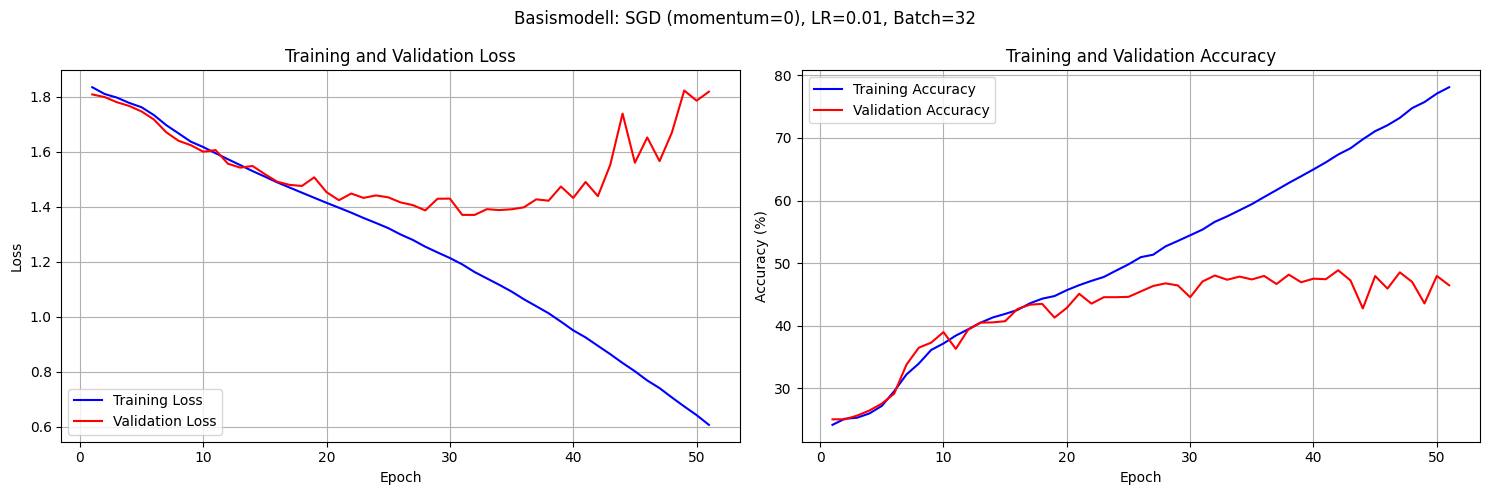

Lernkurven gespeichert als 'plots/baseline_training_curves.png'


In [ ]:
# Lernkurven plotten und speichern
# Sicherstellen, dass plots Verzeichnis existiert
os.makedirs('plots', exist_ok=True)

fig = plot_training_curves(train_losses, val_losses, train_accs, val_accs, 
                          title="Basismodell: SGD (momentum=0), LR=0.01, Batch=32")

# Plot als Bild speichern
fig.savefig('plots/baseline_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Lernkurven gespeichert als 'plots/baseline_training_curves.png'")

### Hyperparameter-Tuning

**Ziel:** Vergleich verschiedener Lernraten und Batch-Größen anhand der Lernkurven und Metriken.

**Testkonfigurationen:**
- **Lernraten:** [0.001, 0.01, 0.1]
- **Batch-Größen:** [16, 32, 64]
- **Epochen:** 60 (konsistent mit Baseline-Training)
- **Optimizer:** SGD ohne Momentum

**Hinweis:** Bei kleinen Datasets wird das Training automatisch beschleunigt.

In [ ]:
# Hyperparameter-Tuning mit wandb Integration
print("=== Hyperparameter-Tuning ===")

# Testkonfigurationen
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64] 
num_epochs = 60  

# Hyperparameter-Tuning mit wandb durchführen
# Modell-Klasse wird als Parameter übergeben
results = hyperparameter_tuning_with_wandb(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    model_class=BaselineCNN, 
    num_epochs=num_epochs,
    img_size=img_size,
    num_classes=num_classes
)

# Finale Speicherbereinigung nach Hyperparameter-Tuning
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()
print("\nHyperparameter-Tuning abgeschlossen - Speicher freigegeben")

=== Hyperparameter-Tuning ===
=== Hyperparameter-Tuning mit wandb ===
Teste 3 Lernraten × 3 Batch-Größen = 9 Konfigurationen

--- LR_0.001_Batch_16 ---


Training startet: 60 Epochen, LR=0.001, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9145 | Val Loss: 1.8767 | Train Acc: 18.62% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8117 | Val Loss: 1.8055 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  10/60 | Train Loss: 1.8093 | Val Loss: 1.8036 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 3/8
Epoch  15/60 | Train Loss: 1.8025 | Val Loss: 1.7960 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.7768 | Val Loss: 1.7737 | Train Acc: 25.91% | Val Acc: 25.72% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.7577 | Val Loss: 1.7551 | Train Acc: 27.13% | Val Acc: 26.68% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.7271 | Val Loss: 1.7235 | Train Acc: 30.08% | Val Acc: 29.83% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.6876 | Val Loss: 1.6848 | Train Acc: 32.97% | Val Acc: 33.19% | Pati

best_val_loss,████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▃▆▁▆█▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▆█▁▁
train_acc,▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
train_f1,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,██████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▆▇█▇▇█▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇██
val_loss,█▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
best_val_loss,1.54363
epoch,60


Finale Validation Accuracy: 40.18% | F1-Score: 0.3795
Beste Validation Accuracy: 40.18% (Epoche 60) | F1-Score: 0.3795
Finale Validation Loss: 1.5436
Speicher nach Variante freigegeben

--- LR_0.001_Batch_32 ---


Training startet: 60 Epochen, LR=0.001, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9229 | Val Loss: 1.8848 | Train Acc: 18.04% | Val Acc: 25.08% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8140 | Val Loss: 1.8075 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.8101 | Val Loss: 1.8037 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.8039 | Val Loss: 1.7977 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.7914 | Val Loss: 1.7854 | Train Acc: 25.16% | Val Acc: 25.06% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.7770 | Val Loss: 1.7729 | Train Acc: 25.85% | Val Acc: 25.34% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.7666 | Val Loss: 1.7627 | Train Acc: 27.24% | Val Acc: 26.25% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.7543 | Val Loss: 1.7489 | Train Acc: 28.32% | Val Acc: 27.71% | Pati

best_val_loss,█▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁█▁▁▁█▁▁▁▁▁▁▁▁
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▇▇▇██
train_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▇▆▇▇▇▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▃▄▄▄▅▆▅▆▆▆▆▆▆▇▇█▇▇█
val_loss,█▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁
best_val_loss,1.64469
epoch,60


Finale Validation Accuracy: 35.28% | F1-Score: 0.3128
Beste Validation Accuracy: 35.28% (Epoche 60) | F1-Score: 0.3128
Finale Validation Loss: 1.6447
Speicher nach Variante freigegeben

--- LR_0.001_Batch_64 ---


Training startet: 60 Epochen, LR=0.001, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9594 | Val Loss: 1.9482 | Train Acc: 14.86% | Val Acc: 16.61% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8494 | Val Loss: 1.8367 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.8145 | Val Loss: 1.8088 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  15/60 | Train Loss: 1.8129 | Val Loss: 1.8072 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 4/8
Epoch  20/60 | Train Loss: 1.8117 | Val Loss: 1.8058 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.8104 | Val Loss: 1.8046 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.8089 | Val Loss: 1.8035 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.8069 | Val Loss: 1.8014 | Train Acc: 25.15% | Val Acc: 25.06% | Pati

best_val_loss,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
patience_counter,▁▁▁▁▁▁▁▃▅▆▁▃▆▁▅▁▃▅▆█▅▁▃▅▃▁▅▁▁▃▃▁▃▁▁▁▁▁▁▁
train_acc,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
train_f1,▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇█
train_loss,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▃▄▂▇█
val_f1,▁▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
val_loss,█▇▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
best_val_loss,1.77595
epoch,60


Finale Validation Accuracy: 25.25% | F1-Score: 0.1178
Beste Validation Accuracy: 25.30% (Epoche 59) | F1-Score: 0.1213
Finale Validation Loss: 1.7760
Speicher nach Variante freigegeben

--- LR_0.01_Batch_16 ---


Training startet: 60 Epochen, LR=0.01, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8251 | Val Loss: 1.8112 | Train Acc: 24.78% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.6912 | Val Loss: 1.6543 | Train Acc: 32.98% | Val Acc: 34.73% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.4781 | Val Loss: 1.4821 | Train Acc: 42.96% | Val Acc: 42.86% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.3026 | Val Loss: 1.3866 | Train Acc: 50.48% | Val Acc: 46.78% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.1127 | Val Loss: 1.3442 | Train Acc: 58.47% | Val Acc: 48.31% | Patience: 0/8
Epoch  25/60 | Train Loss: 0.8897 | Val Loss: 1.3981 | Train Acc: 67.29% | Val Acc: 49.70% | Patience: 5/8

Early Stopping nach 28 Epochen!
Beste Validation Loss: 1.3442 in Epoche 20


best_val_loss,██▇▇▆▅▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
patience_counter,▁▁▁▁▁▁▁▁▂▁▁▂▃▁▁▁▂▃▄▁▂▃▄▅▅▆▇█
train_acc,▁▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
train_f1,▁▁▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▁▁▃▄▄▅▅▅▆▆▆▆▆▇█▇▇███▇▇█████
val_f1,▁▁▂▄▅▄▅▆▅▆▆▆▆▇▇▇▇█▇██▇██████
val_loss,██▇▇▆▅▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▂▃▁▂▃▄▄
best_val_loss,1.34422
epoch,28


Finale Validation Accuracy: 49.95% | F1-Score: 0.4930
Beste Validation Accuracy: 49.95% (Epoche 28) | F1-Score: 0.4930
Finale Validation Loss: 1.5503
Speicher nach Variante freigegeben

--- LR_0.01_Batch_32 ---


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8266 | Val Loss: 1.8053 | Train Acc: 25.01% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.7498 | Val Loss: 1.7273 | Train Acc: 28.79% | Val Acc: 29.92% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.6189 | Val Loss: 1.6187 | Train Acc: 37.16% | Val Acc: 35.96% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.5053 | Val Loss: 1.5192 | Train Acc: 41.99% | Val Acc: 41.57% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.3981 | Val Loss: 1.4587 | Train Acc: 46.70% | Val Acc: 43.57% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.2765 | Val Loss: 1.4185 | Train Acc: 51.87% | Val Acc: 45.58% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.1458 | Val Loss: 1.3955 | Train Acc: 57.07% | Val Acc: 47.16% | Patience: 0/8
Epoch  35/60 | Train Loss: 0.9892 | Val Loss: 1.4679 | Train Acc: 63.79% | Val Acc: 47.61% | Patie

best_val_loss,███▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▃▁▂▁▂▃▁▂▃▄▅▅▆▇█
train_acc,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_f1,▁▁▁▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
val_acc,▁▁▁▂▂▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇█▇█████
val_f1,▁▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▇▆▇▆▆▇▆▇▇▇▇▇▇█▇███████
val_loss,███▇▇▆▆▅▅▅▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▂▂▂▂▃
best_val_loss,1.39551
epoch,38


Finale Validation Accuracy: 47.65% | F1-Score: 0.4714
Beste Validation Accuracy: 49.16% (Epoche 36) | F1-Score: 0.4844
Finale Validation Loss: 1.5279
Speicher nach Variante freigegeben

--- LR_0.01_Batch_64 ---


Training startet: 60 Epochen, LR=0.01, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8537 | Val Loss: 1.8076 | Train Acc: 24.87% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8028 | Val Loss: 1.7927 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.7531 | Val Loss: 1.7507 | Train Acc: 28.22% | Val Acc: 27.88% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.6894 | Val Loss: 1.6678 | Train Acc: 33.27% | Val Acc: 34.12% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.6086 | Val Loss: 1.6020 | Train Acc: 37.72% | Val Acc: 37.18% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.5431 | Val Loss: 1.5537 | Train Acc: 40.71% | Val Acc: 40.06% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.4794 | Val Loss: 1.4972 | Train Acc: 43.16% | Val Acc: 41.68% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.4184 | Val Loss: 1.4743 | Train Acc: 45.97% | Val Acc: 43.17% | Patie

best_val_loss,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▃▅▁▂▃▄▅▆█
train_acc,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_f1,▁▁▁▁▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
train_loss,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
val_acc,▁▁▁▁▁▂▂▃▃▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████▇█████
val_f1,▁▁▁▁▂▂▃▃▄▄▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███▇██
val_loss,████▇▇▆▆▆▆▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▂▂
best_val_loss,1.39792
epoch,60


Finale Validation Accuracy: 46.53% | F1-Score: 0.4643
Beste Validation Accuracy: 47.21% (Epoche 59) | F1-Score: 0.4530
Finale Validation Loss: 1.4461
Speicher nach Variante freigegeben

--- LR_0.1_Batch_16 ---


Training startet: 60 Epochen, LR=0.1, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.7583 | Val Loss: 1.6528 | Train Acc: 28.00% | Val Acc: 32.45% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.2331 | Val Loss: 1.3296 | Train Acc: 52.85% | Val Acc: 49.90% | Patience: 0/8
Epoch  10/60 | Train Loss: 0.9060 | Val Loss: 1.5036 | Train Acc: 66.13% | Val Acc: 50.16% | Patience: 4/8

Early Stopping nach 14 Epochen!
Beste Validation Loss: 1.3104 in Epoche 6


best_val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
patience_counter,▁▁▁▁▁▁▂▃▄▅▅▆▇█
train_acc,▁▃▄▄▅▅▆▆▇▇▇███
train_f1,▁▃▄▅▅▆▆▆▇▇▇███
train_loss,█▇▆▅▄▄▄▃▃▂▂▂▁▁
val_acc,▁▄▆▇██▅████▅▆▆
val_f1,▁▅▆▇▇█▆▇███▆▇▇
val_loss,▅▃▂▁▁▁▄▂▂▄▆▆▇█
best_val_loss,1.31041
epoch,14


Finale Validation Accuracy: 45.63% | F1-Score: 0.4563
Beste Validation Accuracy: 50.85% (Epoche 9) | F1-Score: 0.5079
Finale Validation Loss: 1.8476
Speicher nach Variante freigegeben

--- LR_0.1_Batch_32 ---


Training startet: 60 Epochen, LR=0.1, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8002 | Val Loss: 1.7298 | Train Acc: 25.54% | Val Acc: 28.75% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.3308 | Val Loss: 1.3827 | Train Acc: 48.79% | Val Acc: 46.17% | Patience: 0/8
Epoch  10/60 | Train Loss: 0.9393 | Val Loss: 1.5282 | Train Acc: 64.85% | Val Acc: 49.36% | Patience: 3/8
Epoch  15/60 | Train Loss: 0.5635 | Val Loss: 1.9182 | Train Acc: 79.36% | Val Acc: 51.24% | Patience: 8/8

Early Stopping nach 15 Epochen!
Beste Validation Loss: 1.2944 in Epoche 7


best_val_loss,█▅▄▄▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
patience_counter,▁▁▁▂▁▁▁▂▃▄▅▅▆▇█
train_acc,▁▂▃▄▄▄▅▅▆▆▇▇▇██
train_f1,▁▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▇▆▆▅▅▄▄▄▃▃▂▂▁▁
val_acc,▁▄▅▅▆▆█▇█▇▇█▇▇█
val_f1,▁▄▅▄▇▇███▇███▇█
val_loss,▆▄▃▄▂▂▁▁▁▄▃▃▅▇█
best_val_loss,1.29445
epoch,15


Finale Validation Accuracy: 51.24% | F1-Score: 0.5003
Beste Validation Accuracy: 51.58% (Epoche 9) | F1-Score: 0.5058
Finale Validation Loss: 1.9182
Speicher nach Variante freigegeben

--- LR_0.1_Batch_64 ---


Training startet: 60 Epochen, LR=0.1, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8104 | Val Loss: 1.7771 | Train Acc: 25.08% | Val Acc: 26.26% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.5154 | Val Loss: 1.5254 | Train Acc: 41.26% | Val Acc: 39.92% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.2307 | Val Loss: 1.3718 | Train Acc: 53.46% | Val Acc: 47.74% | Patience: 1/8
Epoch  15/60 | Train Loss: 0.9173 | Val Loss: 1.4961 | Train Acc: 66.17% | Val Acc: 47.72% | Patience: 4/8

Early Stopping nach 19 Epochen!
Beste Validation Loss: 1.3285 in Epoche 11


best_val_loss,█▇▅▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
patience_counter,▁▁▁▁▁▁▁▁▁▂▁▂▃▄▅▅▆▇█
train_acc,▁▁▂▃▃▄▄▄▄▅▅▅▆▆▇▇▇██
train_f1,▁▂▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
val_acc,▁▂▅▅▅▅▆▇▇▇██▇█▇██▇▇
val_f1,▁▂▄▅▅▆▇▇▇▇█████████
val_loss,█▇▅▄▄▄▃▂▁▂▁▁▂▃▄▃▄▇▇
best_val_loss,1.32848
epoch,19


Finale Validation Accuracy: 49.01% | F1-Score: 0.4877
Beste Validation Accuracy: 50.80% (Epoche 16) | F1-Score: 0.4999
Finale Validation Loss: 1.7404
Speicher nach Variante freigegeben

✓ Hyperparameter-Tuning abgeschlossen - Speicher freigegeben


In [ ]:
# Visualisierung der Hyperparameter-Ergebnisse
print("=== Hyperparameter-Vergleich ===")

# Zusammenfassung der Ergebnisse mit F1-Score und bester Performance
summary_data = []
for config_key, result in results.items():
    summary_data.append({
        'Learning Rate': result['learning_rate'],
        'Batch Size': result['batch_size'],
        'Final Train Acc (%)': result['final_train_acc'],
        'Final Val Acc (%)': result['final_val_acc'],
        'Best Val Acc (%)': result.get('best_val_acc', result['final_val_acc']),
        'Final Train F1': result.get('final_train_f1', 0),
        'Final Val F1': result.get('final_val_f1', 0),
        'Best Val F1': result.get('best_val_f1', result.get('final_val_f1', 0)),
        'Final Train Loss': result['final_train_loss'],
        'Final Val Loss': result['final_val_loss'],
        'Epochen': result.get('num_epochs', result.get('best_epoch', len(result.get('val_accs', []))))
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Best Val Acc (%)', ascending=False)
print(df_summary[['Learning Rate', 'Batch Size', 'Best Val Acc (%)', 'Best Val F1', 'Final Val Acc (%)', 'Final Val F1', 'Epochen']].to_string(index=False))

# Beste Konfiguration finden
best_config = df_summary.iloc[0]
print(f"\nBeste Konfiguration:")
print(f"Learning Rate: {best_config['Learning Rate']}")
print(f"Batch Size: {best_config['Batch Size']}")
print(f"Beste Validation Accuracy: {best_config['Best Val Acc (%)']:.2f}% (Epoche {best_config['Epochen']})")
print(f"Beste Validation F1-Score: {best_config['Best Val F1']:.4f}")
print(f"Finale Validation Accuracy: {best_config['Final Val Acc (%)']:.2f}%")
print(f"Finale Validation F1-Score: {best_config['Final Val F1']:.4f}")

=== Hyperparameter-Vergleich ===
Ergebnisse sortiert nach bester Validation Accuracy:
 Learning Rate  Batch Size  Best Val Acc (%)  Best Val F1  Final Val Acc (%)  Final Val F1  Epochen
         0.100          32         51.584814     0.505754          51.236503      0.500338       15
         0.100          16         50.853361     0.507881          45.628701      0.456344       14
         0.100          64         50.801115     0.499867          49.007315      0.487715       19
         0.010          16         49.947753     0.492982          49.947753      0.492982       28
         0.010          32         49.164054     0.484351          47.648903      0.471405       38
         0.010          64         47.213514     0.452971          46.534309      0.464263       60
         0.001          16         40.177638     0.379529          40.177638      0.379529       60
         0.001          32         35.283873     0.312830          35.283873      0.312830       60
         0.001

Hyperparameter-Vergleichsplot gespeichert als 'plots/hyperparameter_comparison.png'


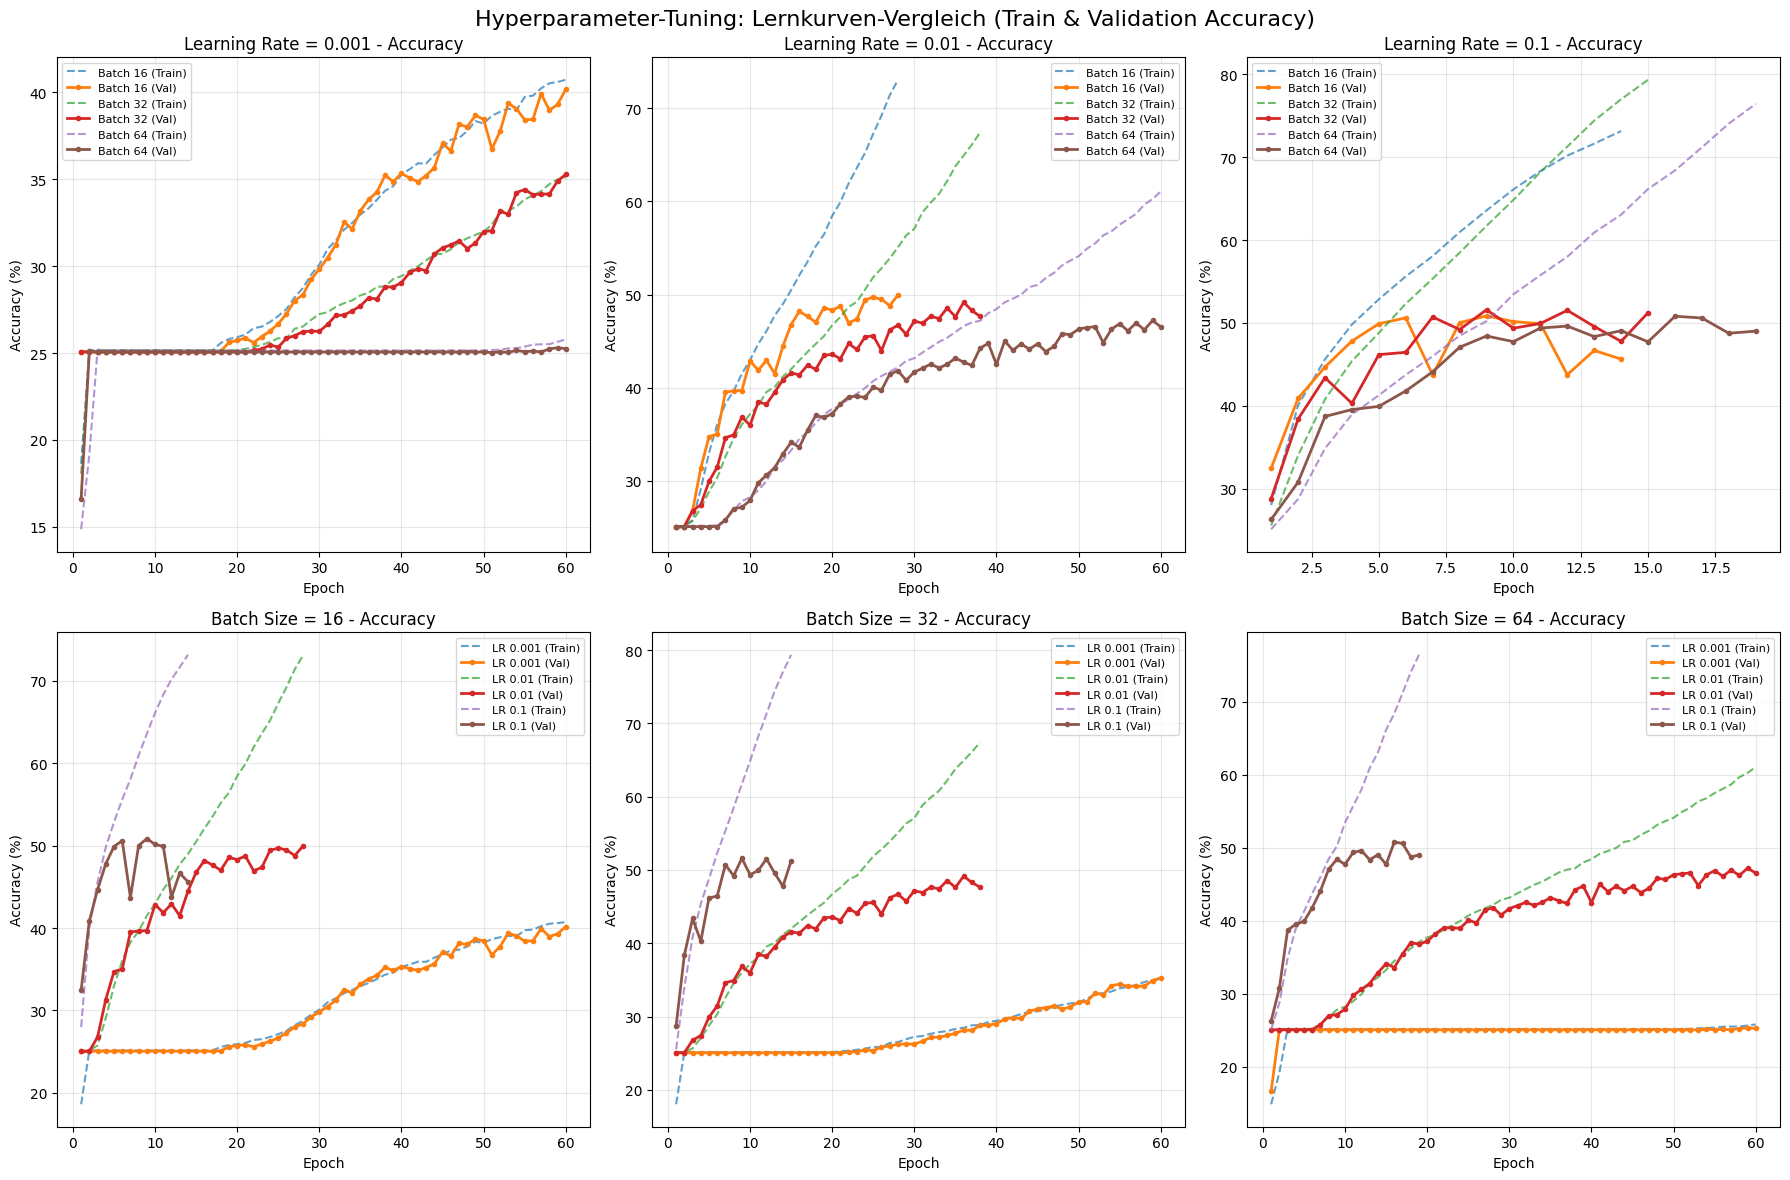

Performance-Übersicht gespeichert als 'plots/hyperparameter_performance_summary.png'


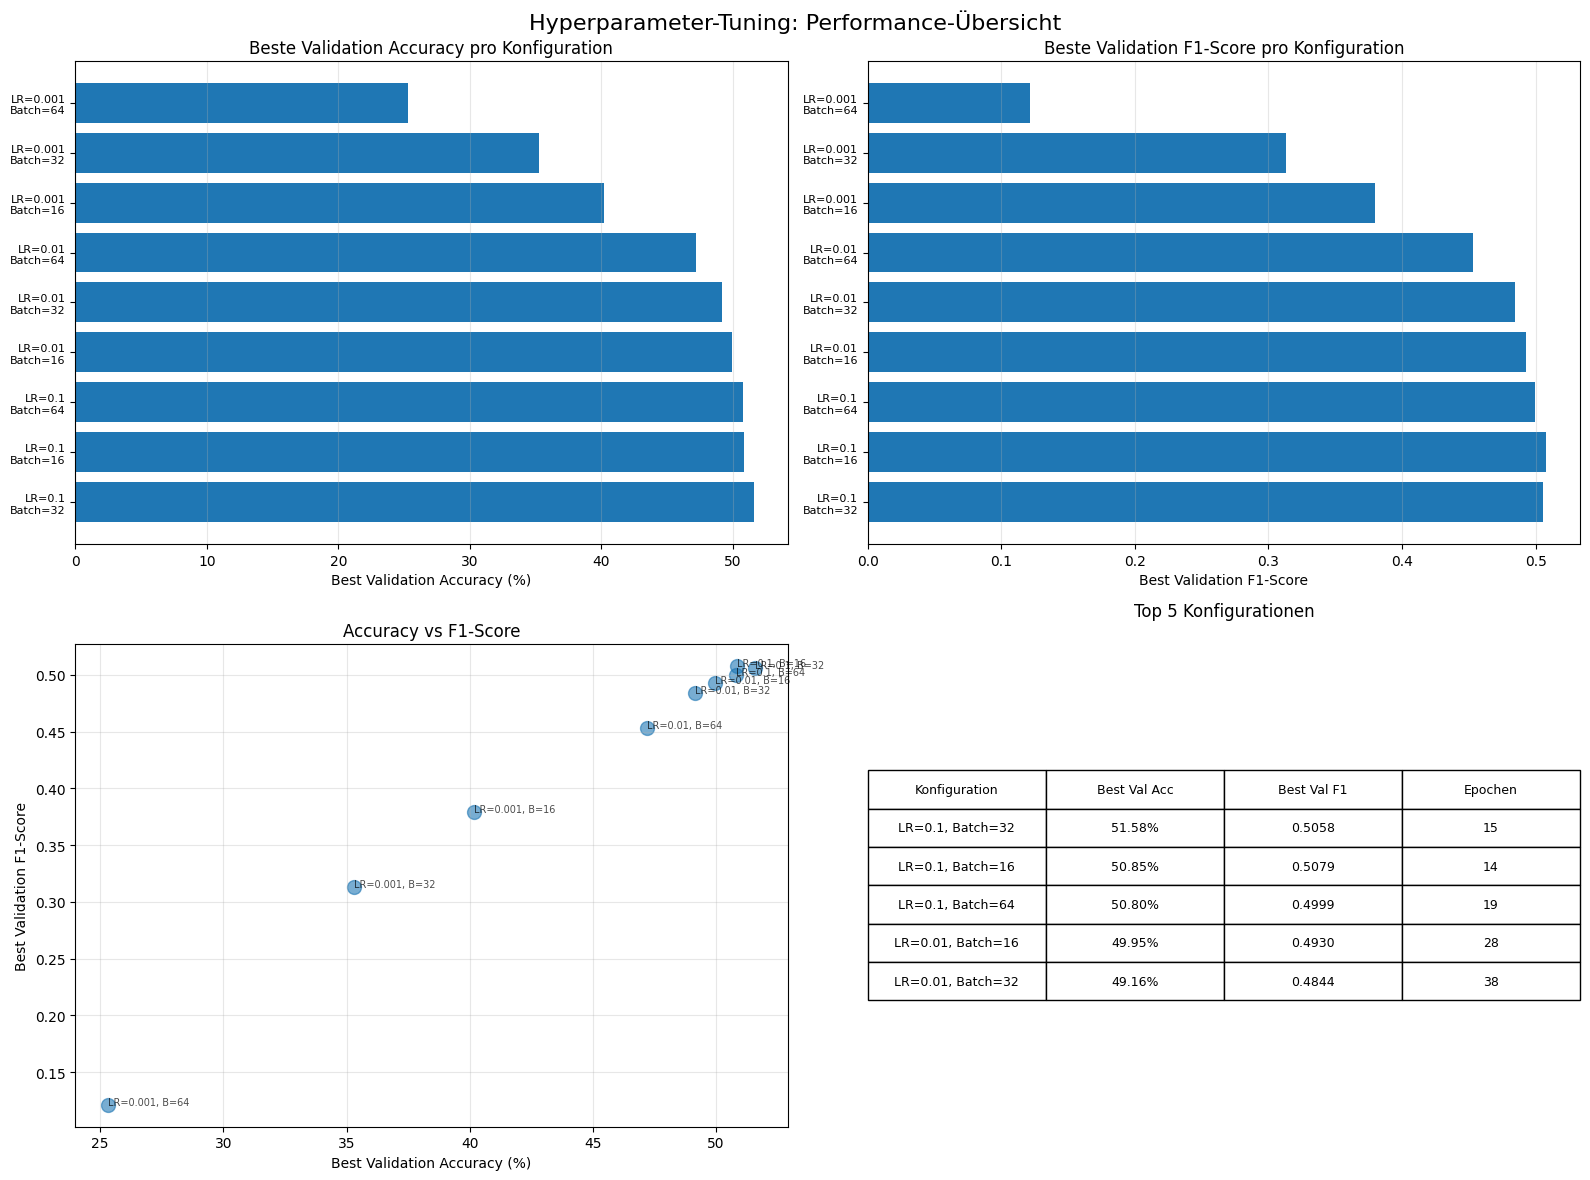

Hyperparameter-Plots gespeichert:
  - plots/hyperparameter_comparison.png
  - plots/hyperparameter_performance_summary.png


In [ ]:
# Lernkurven-Vergleich für verschiedene Konfigurationen 
os.makedirs('plots', exist_ok=True)

fig = plot_hyperparameter_comparison(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_comparison.png'
)

# Performance-Übersicht mit Accuracy, F1-Score, LR und Epochen
fig_perf = plot_hyperparameter_performance_summary(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_performance_summary.png'
)

print("Hyperparameter-Plots gespeichert:")
print("  - plots/hyperparameter_comparison.png")
print("  - plots/hyperparameter_performance_summary.png")

### Cross-Validation für statistische Fehlerschätzung

**Ziel:** Schätzung des statistischen Fehlers der Metriken durch Cross-Validation.

**Konfiguration:**
- **5-Fold Cross-Validation** auf dem Trainingsdatensatz
- **Beste Hyperparameter** aus dem Tuning verwenden
- **60 Epochen pro Fold** (konsistent mit Baseline-Training)
- **Early Stopping deaktiviert** für faire statistische Vergleichbarkeit
- **Statistische Auswertung:** Mittelwert ± Standardabweichung

**Hinweis zu Unsicherheiten:** Die Standardabweichung zeigt die Variabilität zwischen den Folds. 
Eine höhere Standardabweichung deutet auf größere Unsicherheit in den Ergebnissen hin, 
was durch unterschiedliche Datenverteilungen in den Folds oder Modell-Instabilität verursacht werden kann.

In [ ]:
# Cross-Validation für statistische Fehlerschätzung
print("=== Cross-Validation ===")

# Beste Hyperparameter aus dem Tuning verwenden
best_lr = best_config["Learning Rate"]
best_batch = int(best_config["Batch Size"])

print(f"Verwende beste Konfiguration: LR={best_lr}, Batch={best_batch}")

# Cross-Validation durchführen
# Modell-Klasse wird als Parameter übergeben, Early Stopping ist deaktiviert
cv_results = cross_validation_training(
    train_dataset=full_train_dataset,
    model_class=BaselineCNN,  # Modell-Klasse als Parameter
    num_folds=5,
    num_epochs=60,  
    learning_rate=best_lr,
    batch_size=best_batch,
    img_size=img_size,
    num_classes=num_classes
)

print(f"\n=== Cross-Validation Ergebnisse (Mittelwert ± Standardabweichung) ===")
print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")

# F1-Scores ausgeben falls vorhanden
if 'train_f1s' in cv_results:
    print(f"Training F1-Score: {cv_results['train_f1s']['mean']:.4f} ± {cv_results['train_f1s']['std']:.4f}")
    print(f"Validation F1-Score: {cv_results['val_f1s']['mean']:.4f} ± {cv_results['val_f1s']['std']:.4f}")

# Sicherstellen, dass das results Verzeichnis existiert
os.makedirs('results', exist_ok=True)

with open('results/cross_validation_results.json', 'w') as f:
    json.dump({
        'best_hyperparameters': {
            'learning_rate': best_lr,
            'batch_size': best_batch
        },
        'cv_results': cv_results,
        'num_epochs': 60, 
        'note': 'Early Stopping wurde deaktiviert für konsistente Epochenanzahl'
    }, f, indent=2)

print("\nCross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'")

=== Cross-Validation ===
Verwende beste Konfiguration: LR=0.1, Batch=32
WICHTIG: Alle Folds trainieren exakt 60 Epochen (Early Stopping deaktiviert)
Dies stellt sicher, dass die statistische Vergleichbarkeit gewährleistet ist.
Cross-Validation mit 5 Folds
Jeder Fold trainiert exakt 60 Epochen (Early Stopping deaktiviert für Konsistenz)

Fold 1/5
------------------------------
Training startet: 60 Epochen, LR=0.1, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8069 | Val Loss: 1.7599 | Train Acc: 25.02% | Val Acc: 27.01%
Epoch   5/60 | Train Loss: 1.3528 | Val Loss: 1.3521 | Train Acc: 47.66% | Val Acc: 48.38%
Epoch  10/60 | Train Loss: 0.9916 | Val Loss: 1.3311 | Train Acc: 62.66% | Val Acc: 52.49%
Epoch  15/60 | Train Loss: 0.6142 | Val Loss: 1.6960 | Train Acc: 77.63% | Val Acc: 51.90%
Epoch  20/60 | Train Loss: 0.3957 | Val Loss: 2.7129 | Train Acc: 85.95% | Val Acc: 50.66%
Epoch  25/60 | Train Loss: 0.3177 | Val Loss: 3.0033 | Tra

## Hyperparameter-Experimente: Kategorie 1 - Modellkomplexität

**Hinweis:** Die Hypothesen, Erwartungen und Analysen sind im `main.ipynb` dokumentiert. Hier werden nur die Experimente durchgeführt.

**WICHTIG - Experimentdesign:**
Jedes Experiment variiert **nur EINEN Parameter** und hält alle anderen Parameter auf der Baseline-Konfiguration:
- **Baseline-Konfiguration:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen
- **Hypothese 1:** Variiert nur die Anzahl Conv-Layer (2, 3, 4, 5)
- **Hypothese 2:** Variiert nur die Filter-Anzahl pro Layer ([8,16,32], [16,32,64], [32,64,128], [64,128,256])
- **Hypothese 3:** Variiert nur die FC-Layer Breite (32, 64, 128, 256, 512 Neuronen)

Diese isolierte Variation ermöglicht es, den Effekt jedes einzelnen Parameters zu verstehen.

In [ ]:
# Baseline-Ergebnisse laden
baseline_results_file = 'results/baseline_results.json'
with open(baseline_results_file, 'r') as f:
    baseline_results = json.load(f)

# Listen zurück in numpy arrays konvertieren
for key in ['train_losses', 'val_losses', 'train_accs', 'val_accs', 'train_f1s', 'val_f1s']:
    if key in baseline_results and isinstance(baseline_results[key], list):
        baseline_results[key] = np.array(baseline_results[key])

print(f"Baseline-Ergebnisse geladen:")
print(f"  - Parameter: {baseline_results['num_params']:,}")
print(f"  - Beste Val Acc: {baseline_results['best_val_acc']:.2f}% (Epoche {baseline_results['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results['final_val_acc']:.2f}%")
print(f"  - Experiment: {baseline_results['experiment_name']}")

=== Lade gespeicherte Baseline-Ergebnisse ===
Baseline-Ergebnisse geladen:
  - Parameter: 171,271
  - Beste Val Acc: 48.87% (Epoche 42)
  - Finale Val Acc: 46.46%
  - Experiment: baseline_model


### Hypothese 1: Modelltiefe (Anzahl Conv-Layer)

**Variiert:** Nur die Anzahl Conv-Layer (2, 3, 4, 5)  
**Baseline-Parameter:** Filter [16, 32, 64], FC-Layer 64 Neuronen

In [ ]:
# Hypothese 1 Ergebnisse initialisieren
hypothesis_1_file = 'results/hypothesis_1_depth.json'
hypothesis_1_results = {}

# Experiment 1.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 1.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp1 = copy.deepcopy(baseline_results)
baseline_results_hyp1['experiment_name'] = 'hyp1_baseline_3layers'
hypothesis_1_results['3_layers'] = baseline_results_hyp1

# Automatisch speichern
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Experiment 1.2: 2 Layer
print("\n" + "-"*60)
print("Experiment 1.2: 2 Conv-Layer")
print("Filter: [16, 32]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_2 = run_hyperparameter_experiment(
    experiment_name="hyp1_2layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 2,  
        'filters_per_layer': [16, 32]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 

    use_wandb=True
)
hypothesis_1_results['2_layers'] = result_2

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 1.3: 4 Layer
print("\n" + "-"*60)
print("Experiment 1.3: 4 Conv-Layer")
print("Filter: [16, 32, 64, 128]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_4 = run_hyperparameter_experiment(
    experiment_name="hyp1_4layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 4, 
        'filters_per_layer': [16, 32, 64, 128] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 

    use_wandb=True
)
hypothesis_1_results['4_layers'] = result_4

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 1.4: 6 Layer
print("\n" + "-"*60)
print("Experiment 1.4: 6 Conv-Layer")
print("Filter: [16, 32, 64, 128, 256, 512]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("Pooling: Nach Layer 1, 2, 3 (wie Baseline), dann kein Pooling mehr")
print("-"*60)

result_6 = run_hyperparameter_experiment(
    experiment_name="hyp1_6layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 6, 
        'filters_per_layer': [16, 32, 64, 128, 256, 512],
        'pool_after_layers': [0, 1, 2]  # Pooling nur nach den ersten 3 Layern
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32,  

    use_wandb=True
)
hypothesis_1_results['6_layers'] = result_6

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

In [ ]:
# Analyse und Visualisierung Hypothese 1
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 1: MODELLTIEFE")
print("="*80)

# Zusammenfassungstabelle
summary_data = []
for name, result in hypothesis_1_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Finale Val F1': f"{result['final_val_f1']:.4f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}",
        'Beste Epoche': result['best_epoch']
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
os.makedirs('plots/experiments', exist_ok=True)

fig = plot_experiment_comparison(hypothesis_1_results, metric='val_acc', 
                                 title='Hypothese 1: Modelltiefe - Validation Accuracy')
plt.savefig('plots/experiments/hyp1_depth_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_1_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp1_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_1_results, 
                                     title='Hypothese 1: Modelltiefe - Trainingskurven')
plt.savefig('plots/experiments/hyp1_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_1_results, 'results/hypothesis_1_depth.json')
print("\nErgebnisse gespeichert: results/hypothesis_1_depth.json")

### Hypothese 2: Modellbreite (Filter-Anzahl)

**Variiert:** Nur die Filter-Anzahl pro Layer ([8, 16, 32], [16, 32, 64], [32, 64, 128], [64, 128, 256])  
**Konstant:** 3 Conv-Layer (Baseline), FC-Layer 64 Neuronen (Baseline)

In [ ]:
# Hypothese 2 Ergebnisse initialisieren
hypothesis_2_file = 'results/hypothesis_2_depth.json'
hypothesis_2_results = {}

# Experiment 2.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 2.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp2 = copy.deepcopy(baseline_results)
baseline_results_hyp2['experiment_name'] = 'hyp2_baseline_3layers'
hypothesis_2_results['16_32_64'] = baseline_results_hyp2

# Automatisch speichern
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Experiment 2.2: [8, 16, 32] Filter
print("\n" + "-"*60)
print("Experiment 2.2: [8, 16, 32] Filter")
print("-"*60)

result_narrow = run_hyperparameter_experiment(
    experiment_name="hyp2_narrow_8_16_32",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [8, 16, 32] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32,  

    use_wandb=True
)
hypothesis_2_results['8_16_32'] = result_narrow

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 2.3: [32, 64, 128] Filter
print("\n" + "-"*60)
print("Experiment 2.3: [32, 64, 128] Filter")
print("-"*60)

result_wide1 = run_hyperparameter_experiment(
    experiment_name="hyp2_wide_32_64_128",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [32, 64, 128]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_2_results['32_64_128'] = result_wide1

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 2.4: [64, 128, 256] Filter
print("\n" + "-"*60)
print("Experiment 2.4: [64, 128, 256] Filter")
print("-"*60)

result_wide2 = run_hyperparameter_experiment(
    experiment_name="hyp2_very_wide_64_128_256",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [64, 128, 256]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_2_results['64_128_256'] = result_wide2

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


In [ ]:
# Analyse und Visualisierung Hypothese 2
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 2: MODELLBREITE")
print("="*80)

summary_data = []
for name, result in hypothesis_2_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
fig = plot_experiment_comparison(hypothesis_2_results, metric='val_acc', 
                                 title='Hypothese 2: Modellbreite - Validation Accuracy')
plt.savefig('plots/experiments/hyp2_width_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_2_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp2_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_2_results, 
                                     title='Hypothese 2: Modellbreite - Trainingskurven')
plt.savefig('plots/experiments/hyp2_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_2_results, 'results/hypothesis_2_width.json')
print("\nErgebnisse gespeichert: results/hypothesis_2_width.json")

### Hypothese 3: FC-Layer Breite (Anzahl Neuronen)

**Variiert:** Nur die FC-Layer Breite (32, 64, 128, 256, 512 Neuronen)  
**Konstant:** 3 Conv-Layer (Baseline), Filter [16, 32, 64] (Baseline)

In [ ]:
# Hypothese 3 Ergebnisse initialisieren
hypothesis_3_file = 'results/hypothesis_3_fc_width.json'
hypothesis_3_results = {}

# Experiment 3.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 3.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp3 = copy.deepcopy(baseline_results)
baseline_results_hyp3['experiment_name'] = 'hyp3_baseline_3layers'
hypothesis_3_results['64_units'] = baseline_results_hyp3

# Automatisch speichern
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Experiment 3.2: 32 Neuronen
print("\n" + "-"*60)
print("Experiment 3.2: 32 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_32 = run_hyperparameter_experiment(
    experiment_name="hyp3_32_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 32  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_3_results['32_units'] = result_32

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 3.3: 128 Neuronen
print("\n" + "-"*60)
print("Experiment 3.3: 128 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_128 = run_hyperparameter_experiment(
    experiment_name="hyp3_128_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 128  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32,  

    use_wandb=True
)
hypothesis_3_results['128_units'] = result_128

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 3.4: 256 Neuronen
print("\n" + "-"*60)
print("Experiment 3.4: 256 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_256 = run_hyperparameter_experiment(
    experiment_name="hyp3_256_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [16, 32, 64],
        'fc_units': 256  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_3_results['256_units'] = result_256

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 3.5: 512 Neuronen
print("\n" + "-"*60)
print("Experiment 3.5: 512 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_512 = run_hyperparameter_experiment(
    experiment_name="hyp3_512_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 512  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_3_results['512_units'] = result_512

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


In [ ]:
# Analyse und Visualisierung Hypothese 3
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 3: FC-LAYER BREITE")
print("="*80)

summary_data = []
for name, result in hypothesis_3_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
fig = plot_experiment_comparison(hypothesis_3_results, metric='val_acc', 
                                 title='Hypothese 3: FC-Layer Breite - Validation Accuracy')
plt.savefig('plots/experiments/hyp3_fc_width_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_3_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp3_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_3_results, 
                                     title='Hypothese 3: FC-Layer Breite - Trainingskurven')
plt.savefig('plots/experiments/hyp3_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_3_results, 'results/hypothesis_3_fc_width.json')
print("\nErgebnisse gespeichert: results/hypothesis_3_fc_width.json")

### Zusammenfassung Kategorie 1

ZUSAMMENFASSUNG: KATEGORIE 1 - MODELLKOMPLEXITÄT

Beste Konfigurationen pro Hypothese:
Hypothese             Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
Hyp1_Best              hyp1_4layers   171,399             50.70              49.56               30.50
Hyp2_Best hyp2_very_wide_64_128_256   960,007             52.46              50.73               31.16
Hyp3_Best            hyp3_128_units   319,239             49.86              49.53               34.97

GESAMTBESTE KONFIGURATION: Hyp2_Best
Experiment: hyp2_very_wide_64_128_256
Beste Validation Accuracy: 52.46%
Finale Validation Accuracy: 50.73%
Overfitting-Gap: 31.16%
Modell-Parameter: 960,007


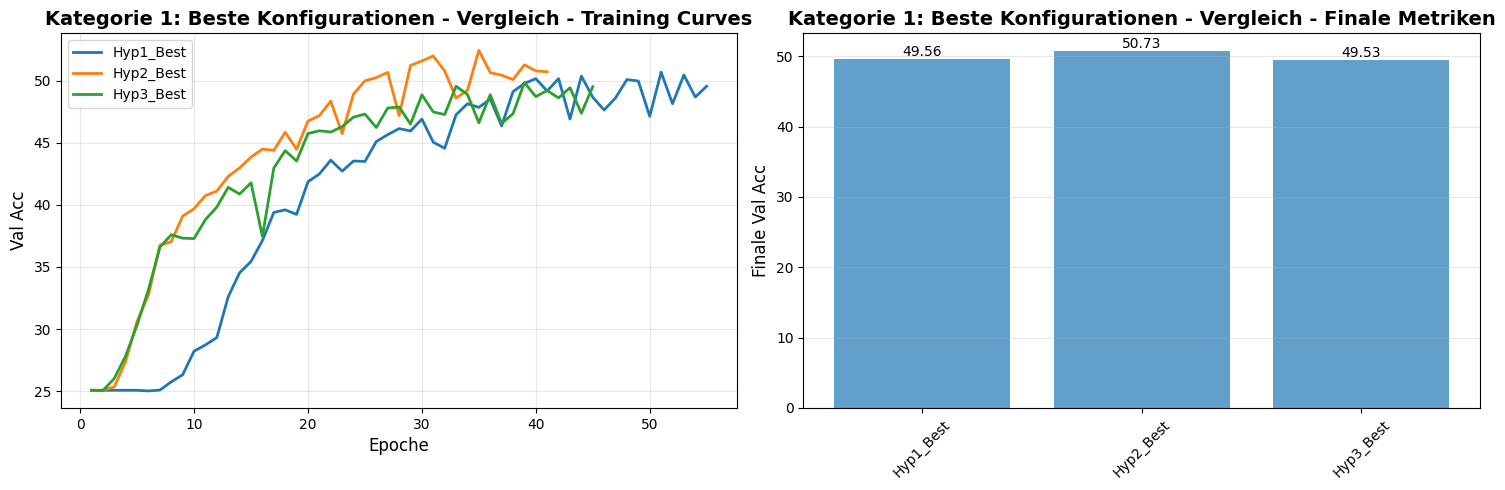

Ergebnisse gespeichert: results/category1_all_results.json

Alle Ergebnisse gespeichert: results/category1_all_results.json


In [24]:
# Zusammenfassung aller Experimente
print("="*80)
print("ZUSAMMENFASSUNG: KATEGORIE 1 - MODELLKOMPLEXITÄT")
print("="*80)

# Beste Konfigurationen aus jeder Hypothese
best_hyp1 = max(hypothesis_1_results.keys(), 
                key=lambda k: hypothesis_1_results[k]['best_val_acc'])
best_hyp2 = max(hypothesis_2_results.keys(), 
                key=lambda k: hypothesis_2_results[k]['best_val_acc'])
best_hyp3 = max(hypothesis_3_results.keys(), 
                key=lambda k: hypothesis_3_results[k]['best_val_acc'])

summary_all = {
    'Hyp1_Best': hypothesis_1_results[best_hyp1],
    'Hyp2_Best': hypothesis_2_results[best_hyp2],
    'Hyp3_Best': hypothesis_3_results[best_hyp3]
}

# Vergleichstabelle
comparison_data = []
for name, result in summary_all.items():
    comparison_data.append({
        'Hypothese': name,
        'Konfiguration': result['experiment_name'],
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBeste Konfigurationen pro Hypothese:")
print(df_comparison.to_string(index=False))

# Gesamtbeste Konfiguration
overall_best = max(summary_all.keys(), 
                  key=lambda k: summary_all[k]['best_val_acc'])
overall_best_result = summary_all[overall_best]

print(f"\n{'='*80}")
print(f"GESAMTBESTE KONFIGURATION: {overall_best}")
print(f"{'='*80}")
print(f"Experiment: {overall_best_result['experiment_name']}")
print(f"Beste Validation Accuracy: {overall_best_result['best_val_acc']:.2f}%")
print(f"Finale Validation Accuracy: {overall_best_result['final_val_acc']:.2f}%")
print(f"Overfitting-Gap: {overall_best_result['overfitting_gap_acc']:.2f}%")
print(f"Modell-Parameter: {overall_best_result['num_params']:,}")

# Visualisierung aller besten Konfigurationen
fig = plot_experiment_comparison(summary_all, metric='val_acc', 
                                 title='Kategorie 1: Beste Konfigurationen - Vergleich')
plt.savefig('plots/experiments/category1_best_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Alle Ergebnisse speichern
all_results = {
    'hypothesis_1': hypothesis_1_results,
    'hypothesis_2': hypothesis_2_results,
    'hypothesis_3': hypothesis_3_results,
    'summary': {
        'best_hyp1': best_hyp1,
        'best_hyp2': best_hyp2,
        'best_hyp3': best_hyp3,
        'overall_best': overall_best
    }
}

save_experiment_results(all_results, 'results/category1_all_results.json')
print("\nAlle Ergebnisse gespeichert: results/category1_all_results.json")

## Hyperparameter-Experimente: Kategorie 2 - Conv-Layer Settings

**Übersicht:**
- **Hypothese 4:** Variiert nur die Kernel-Größe (3x3, 5x5, 7x7)
- **Hypothese 5:** Variiert nur die Pooling-Strategie (MaxPool2d, AvgPool2d, AdaptiveAvgPool2d)

**Baseline-Parameter für alle Experimente:**
- 3 Conv-Layer
- Filter [16, 32, 64]
- FC-Layer 64 Neuronen
- LR=0.01, Batch=32, 60 Epochen

### Hypothese 4: Kernel Size

**Variiert:** Nur die Kernel-Größe (3x3 Baseline, 5x5, 7x7)  
**Konstant:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen, MaxPool2d

In [ ]:
# Hypothese 4 Ergebnisse initialisieren
hypothesis_4_file = 'results/hypothesis_4_kernel_size.json'
hypothesis_4_results = {}

# Experiment 4.1: Baseline (3x3 Kernel)
print("\n" + "-"*60)
print("Experiment 4.1: Baseline (3x3 Kernel)")
print("Kernel Size: 3x3 (Baseline)")
print("Pooling: MaxPool2d(2x2)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
baseline_results_hyp4 = copy.deepcopy(baseline_results)
baseline_results_hyp4['experiment_name'] = 'hyp4_baseline_3x3_kernel'
hypothesis_4_results['kernel_3x3'] = baseline_results_hyp4

# Automatisch speichern
save_hypothesis_results(hypothesis_4_results, hypothesis_4_file)

# Experiment 4.2: 5x5 Kernel
print("\n" + "-"*60)
print("Experiment 4.2: 5x5 Kernel")
print("Kernel Size: 5x5")
print("Pooling: MaxPool2d(2x2)")
print("-"*60)

result_5x5 = run_hyperparameter_experiment(
    experiment_name='hyp4_5x5_kernel',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 5,
        'fc_units': 64,
        'pooling_type': 'max'
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_4_results['kernel_5x5'] = result_5x5
save_hypothesis_results(hypothesis_4_results, hypothesis_4_file)

# Experiment 4.3: 7x7 Kernel
print("\n" + "-"*60)
print("Experiment 4.3: 7x7 Kernel")
print("Kernel Size: 7x7")
print("Pooling: MaxPool2d(2x2)")
print("-"*60)

result_7x7 = run_hyperparameter_experiment(
    experiment_name='hyp4_7x7_kernel',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 7,
        'fc_units': 64,
        'pooling_type': 'max'
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_4_results['kernel_7x7'] = result_7x7
save_hypothesis_results(hypothesis_4_results, hypothesis_4_file)


In [ ]:
# Analyse und Visualisierung Hypothese 4
print("="*80)
print("ANALYSE HYPOTHESE 4: KERNEL SIZE")
print("="*80)

# Vergleichstabelle
summary_data = []
for name, result in hypothesis_4_results.items():
    summary_data.append({
        'Kernel Size': name.replace('kernel_', '').replace('x', '×'),
        'Parameter': f"{result.get('num_params', 0):,}",
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung Hypothese 4:")
print(df_summary.to_string(index=False))

# Plots
plot_experiment_comparison(hypothesis_4_results, metric='val_acc',
                         title='Hypothese 4: Kernel Size - Validation Accuracy')
plt.savefig('plots/experiments/hyp4_kernel_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_4_results,
                                title='Hypothese 4: Kernel Size - Trainingskurven')
plt.savefig('plots/experiments/hyp4_kernel_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Hypothese 5: Pooling-Strategie

**Variiert:** Nur die Pooling-Strategie (MaxPool2d Baseline, AvgPool2d, AdaptiveAvgPool2d)  
**Konstant:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen, Kernel 3x3

In [ ]:
# Hypothese 5 Ergebnisse initialisieren
hypothesis_5_file = 'results/hypothesis_5_pooling.json'
hypothesis_5_results = {}

# Experiment 5.1: Baseline (MaxPool2d)
print("\n" + "-"*60)
print("Experiment 5.1: Baseline (MaxPool2d)")
print("Pooling: MaxPool2d(2x2) (Baseline)")
print("Kernel Size: 3x3")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
baseline_results_hyp5 = copy.deepcopy(baseline_results)
baseline_results_hyp5['experiment_name'] = 'hyp5_baseline_maxpool'
hypothesis_5_results['maxpool'] = baseline_results_hyp5

print(f"Baseline-Ergebnisse:")
print(f"  - Beste Val Acc: {baseline_results_hyp5['best_val_acc']:.2f}% (Epoche {baseline_results_hyp5['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results_hyp5['final_val_acc']:.2f}%")

# Automatisch speichern
save_hypothesis_results(hypothesis_5_results, hypothesis_5_file)

# Experiment 5.2: AvgPool2d
print("\n" + "-"*60)
print("Experiment 5.2: AvgPool2d")
print("Pooling: AvgPool2d(2x2)")
print("Kernel Size: 3x3")
print("-"*60)

result_avgpool = run_hyperparameter_experiment(
    experiment_name='hyp5_avgpool',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 3,
        'fc_units': 64,
        'pooling_type': 'avg'
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_5_results['avgpool'] = result_avgpool
save_hypothesis_results(hypothesis_5_results, hypothesis_5_file)

# Experiment 5.3: AdaptiveAvgPool2d
print("\n" + "-"*60)
print("Experiment 5.3: AdaptiveAvgPool2d")
print("Pooling: AdaptiveAvgPool2d(6x6)")
print("Kernel Size: 3x3")
print("-"*60)

result_adaptive = run_hyperparameter_experiment(
    experiment_name='hyp5_adaptive_pool',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 3,
        'fc_units': 64,
        'pooling_type': 'adaptive'
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_5_results['adaptive'] = result_adaptive
save_hypothesis_results(hypothesis_5_results, hypothesis_5_file)

# Analyse und Visualisierung Hypothese 5
print("="*80)
print("ANALYSE HYPOTHESE 5: POOLING-STRATEGIE")
print("="*80)

# Vergleichstabelle
summary_data = []
for name, result in hypothesis_5_results.items():
    summary_data.append({
        'Pooling': name.replace('pool', 'Pool').title(),
        'Parameter': f"{result.get('num_params', 0):,}",
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung Hypothese 5:")
print(df_summary.to_string(index=False))

# Plots
plot_experiment_comparison(hypothesis_5_results, metric='val_acc',
                         title='Hypothese 5: Pooling-Strategie - Validation Accuracy')
plt.savefig('plots/experiments/hyp5_pooling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_5_results,
                                title='Hypothese 5: Pooling-Strategie - Trainingskurven')
plt.savefig('plots/experiments/hyp5_pooling_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Zusammenfassung Kategorie 2

In [ ]:
# Zusammenfassung aller Experimente Kategorie 2
print("="*80)
print("ZUSAMMENFASSUNG: KATEGORIE 2 - CONV-LAYER SETTINGS")
print("="*80)

# Beste Konfigurationen aus jeder Hypothese
best_hyp4 = max(hypothesis_4_results.keys(), 
                key=lambda k: hypothesis_4_results[k]['best_val_acc'])
best_hyp5 = max(hypothesis_5_results.keys(), 
                key=lambda k: hypothesis_5_results[k]['best_val_acc'])

summary_all = {
    'Hyp4_Best': hypothesis_4_results[best_hyp4],
    'Hyp5_Best': hypothesis_5_results[best_hyp5]
}

# Vergleichstabelle
comparison_data = []
for name, result in summary_all.items():
    comparison_data.append({
        'Hypothese': name,
        'Konfiguration': result['experiment_name'],
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBeste Konfigurationen pro Hypothese:")
print(df_comparison.to_string(index=False))

# Gesamtbeste Konfiguration
overall_best = max(summary_all.keys(), 
                  key=lambda k: summary_all[k]['best_val_acc'])
overall_best_result = summary_all[overall_best]

print(f"\n{'='*80}")
print(f"GESAMTBESTE KONFIGURATION: {overall_best}")
print(f"{'='*80}")
print(f"Experiment: {overall_best_result['experiment_name']}")
print(f"Beste Validation Accuracy: {overall_best_result['best_val_acc']:.2f}%")
print(f"Finale Validation Accuracy: {overall_best_result['final_val_acc']:.2f}%")
print(f"Overfitting-Gap: {overall_best_result['overfitting_gap_acc']:.2f}%")
print(f"Modell-Parameter: {overall_best_result['num_params']:,}")

# Visualisierung aller besten Konfigurationen
fig = plot_experiment_comparison(summary_all, metric='val_acc', 
                                 title='Kategorie 2: Beste Konfigurationen - Vergleich')
plt.savefig('plots/experiments/category2_best_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Alle Ergebnisse speichern
all_results = {
    'hypothesis_4': hypothesis_4_results,
    'hypothesis_5': hypothesis_5_results,
    'summary': {
        'best_hyp4': best_hyp4,
        'best_hyp5': best_hyp5,
        'overall_best': overall_best
    }
}

save_experiment_results(all_results, 'results/category2_all_results.json')
print("\nAlle Ergebnisse gespeichert: results/category2_all_results.json")

## Hyperparameter-Experimente: Kategorie 3 - Regularisierung

**Übersicht:**
- **Hypothese 6:** Variiert nur Dropout-Rate (0.0, 0.2, 0.3, 0.5)
- **Hypothese 7:** Variiert Data Augmentation (keine, Rotation, Flip, Translation, Kombination)

**Baseline-Parameter für alle Experimente:**
- 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen
- Kernel 3x3, MaxPool2d
- LR=0.01, Batch=32, 60 Epochen, SGD

### Hypothese 6: Dropout

**Variiert:** Nur die Dropout-Rate (0.0 Baseline, 0.2, 0.3, 0.5)  
**Konstant:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen, Kernel 3x3, MaxPool2d

In [ ]:
# Hypothese 6 Ergebnisse initialisieren
hypothesis_6_file = 'results/hypothesis_6_dropout.json'
hypothesis_6_results = {}

# Experiment 6.1: Baseline (kein Dropout)
print("\n" + "-"*60)
print("Experiment 6.1: Baseline (kein Dropout)")
print("Dropout: 0.0 (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
baseline_results_hyp6 = copy.deepcopy(baseline_results)
baseline_results_hyp6['experiment_name'] = 'hyp6_baseline_no_dropout'
hypothesis_6_results['dropout_0.0'] = baseline_results_hyp6

print(f"Baseline-Ergebnisse:")
print(f"  - Beste Val Acc: {baseline_results_hyp6['best_val_acc']:.2f}% (Epoche {baseline_results_hyp6['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results_hyp6['final_val_acc']:.2f}%")

save_hypothesis_results(hypothesis_6_results, hypothesis_6_file)

# Experiment 6.2-6.4: Dropout 0.2, 0.3, 0.5
dropout_rates = [0.2, 0.3, 0.5]

for dropout_rate in dropout_rates:
    print("\n" + "-"*60)
    print(f"Experiment 6.{dropout_rates.index(dropout_rate)+2}: Dropout {dropout_rate}")
    print(f"Dropout: {dropout_rate}")
    print("-"*60)
    
    result = run_hyperparameter_experiment(
        experiment_name=f'hyp6_dropout_{dropout_rate}',
        model_class=FlexibleCNN,
        model_kwargs={
            'img_size': img_size,
            'num_classes': num_classes,
            'num_conv_layers': 3,
            'filters_per_layer': [16, 32, 64],
            'kernel_size': 3,
            'fc_units': 64,
            'pooling_type': 'max',
            'dropout_rate': dropout_rate,
            'use_batchnorm': False
        },
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=60,
        learning_rate=0.01,
        batch_size=32,
    
        use_wandb=True
    )
    
    hypothesis_6_results[f'dropout_{dropout_rate}'] = result
    save_hypothesis_results(hypothesis_6_results, hypothesis_6_file)


In [ ]:
# Analyse und Visualisierung Hypothese 6
print("="*80)
print("ANALYSE HYPOTHESE 6: DROPOUT")
print("="*80)

summary_data = []
for name, result in hypothesis_6_results.items():
    summary_data.append({
        'Dropout Rate': name.replace('dropout_', ''),
        'Parameter': f"{result.get('num_params', 0):,}",
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung Hypothese 6:")
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_6_results, metric='val_acc',
                         title='Hypothese 6: Dropout - Validation Accuracy')
plt.savefig('plots/experiments/hyp6_dropout_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_6_results,
                                title='Hypothese 6: Dropout - Trainingskurven')
plt.savefig('plots/experiments/hyp6_dropout_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Hypothese 7: Data Augmentation

**Variiert:** Nur Data Augmentation (keine Baseline, Rotation, Flip, Translation, Kombination)  
**Konstant:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen, Kernel 3x3, MaxPool2d, kein Dropout

In [ ]:
# Hypothese 7: Data Augmentation
# Verschiedene Augmentation-Strategien definieren
augmentation_configs = {
    'none': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]),
    'rotation': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ]),
    'flip': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ]),
    'translation': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ]),
    'combination': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ])
}

# Validation transform (immer ohne Augmentation)
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

hypothesis_7_file = 'results/hypothesis_7_augmentation.json'
hypothesis_7_results = {}

# Experiment 7.1: Baseline (keine Augmentation)
print("\n" + "-"*60)
print("Experiment 7.1: Baseline (keine Augmentation)")
print("Augmentation: keine")
print("-"*60)

baseline_results_hyp7 = copy.deepcopy(baseline_results)
baseline_results_hyp7['experiment_name'] = 'hyp7_baseline_no_aug'
hypothesis_7_results['no_aug'] = baseline_results_hyp7

save_hypothesis_results(hypothesis_7_results, hypothesis_7_file)

# Experiment 7.2-7.5: Verschiedene Augmentation-Strategien
for aug_name, aug_transform in augmentation_configs.items():
    if aug_name == 'none':
        continue  # Bereits als Baseline gemacht
    
    print("\n" + "-"*60)
    print(f"Experiment 7.{list(augmentation_configs.keys()).index(aug_name)+1}: {aug_name.title()} Augmentation")
    print(f"Augmentation: {aug_name}")
    print("-"*60)
    
# Neue Datasets mit Augmentation erstellen
    aug_train_dataset = datasets.ImageFolder(root=train_dir, transform=aug_transform)
    aug_val_dataset = datasets.ImageFolder(root=train_dir, transform=val_transform)
    
# Split neu erstellen
    aug_train_size = int(0.8 * len(aug_train_dataset))
    aug_val_size = len(aug_train_dataset) - aug_train_size
    aug_train_subset, aug_val_subset = random_split(
        aug_train_dataset, 
        [aug_train_size, aug_val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
# Val-Dataset für Evaluation (ohne Augmentation)
    aug_val_eval_dataset = datasets.ImageFolder(root=train_dir, transform=val_transform)
    _, aug_val_eval_subset = random_split(
        aug_val_eval_dataset,
        [aug_train_size, aug_val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
# DataLoader erstellen
    optimal_workers = min(12, get_optimal_num_workers())
    use_pin_memory = should_use_pin_memory()
    
    aug_train_loader = DataLoader(
        aug_train_subset,
        batch_size=32,
        shuffle=True,
        num_workers=optimal_workers,
        pin_memory=use_pin_memory
    )
    
    aug_val_loader = DataLoader(
        aug_val_eval_subset,
        batch_size=32,
        shuffle=False,
        num_workers=optimal_workers,
        pin_memory=use_pin_memory
    )
    
# Experiment durchführen
    result = run_hyperparameter_experiment(
        experiment_name=f'hyp7_aug_{aug_name}',
        model_class=FlexibleCNN,
        model_kwargs={
            'img_size': img_size,
            'num_classes': num_classes,
            'num_conv_layers': 3,
            'filters_per_layer': [16, 32, 64],
            'kernel_size': 3,
            'fc_units': 64,
            'pooling_type': 'max',
            'dropout_rate': 0.0,
            'use_batchnorm': False
        },
        train_loader=aug_train_loader,
        val_loader=aug_val_loader,
        test_loader=test_loader,
        num_epochs=60,
        learning_rate=0.01,
        batch_size=32,
    
        use_wandb=True
    )
    
    hypothesis_7_results[aug_name] = result
    save_hypothesis_results(hypothesis_7_results, hypothesis_7_file)


In [ ]:
# Analyse und Visualisierung Hypothese 7
print("="*80)
print("ANALYSE HYPOTHESE 7: DATA AUGMENTATION")
print("="*80)

summary_data = []
for name, result in hypothesis_7_results.items():
    summary_data.append({
        'Augmentation': name.replace('_', ' ').title(),
        'Parameter': f"{result.get('num_params', 0):,}",
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung Hypothese 7:")
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_7_results, metric='val_acc',
                         title='Hypothese 7: Data Augmentation - Validation Accuracy')
plt.savefig('plots/experiments/hyp7_augmentation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_7_results,
                                title='Hypothese 7: Data Augmentation - Trainingskurven')
plt.savefig('plots/experiments/hyp7_augmentation_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Zusammenfassung Kategorie 3

In [ ]:
# Zusammenfassung Kategorie 3
print("="*80)
print("ZUSAMMENFASSUNG: KATEGORIE 3 - REGULARISIERUNG")
print("="*80)

best_hyp6 = max(hypothesis_6_results.keys(), 
                key=lambda k: hypothesis_6_results[k]['best_val_acc'])
best_hyp7 = max(hypothesis_7_results.keys(), 
                key=lambda k: hypothesis_7_results[k]['best_val_acc'])

summary_all = {
    'Hyp6_Best': hypothesis_6_results[best_hyp6],
    'Hyp7_Best': hypothesis_7_results[best_hyp7]
}

comparison_data = []
for name, result in summary_all.items():
    comparison_data.append({
        'Hypothese': name,
        'Konfiguration': result['experiment_name'],
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBeste Konfigurationen pro Hypothese:")
print(df_comparison.to_string(index=False))

overall_best = max(summary_all.keys(), 
                  key=lambda k: summary_all[k]['best_val_acc'])
overall_best_result = summary_all[overall_best]

print(f"\n{'='*80}")
print(f"GESAMTBESTE KONFIGURATION: {overall_best}")
print(f"{'='*80}")
print(f"Experiment: {overall_best_result['experiment_name']}")
print(f"Beste Validation Accuracy: {overall_best_result['best_val_acc']:.2f}%")

fig = plot_experiment_comparison(summary_all, metric='val_acc', 
                                 title='Kategorie 3: Beste Konfigurationen - Vergleich')
plt.savefig('plots/experiments/category3_best_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

all_results = {
    'hypothesis_6': hypothesis_6_results,
    'hypothesis_7': hypothesis_7_results,
    'summary': {
        'best_hyp6': best_hyp6,
        'best_hyp7': best_hyp7,
        'overall_best': overall_best
    }
}

save_experiment_results(all_results, 'results/category3_all_results.json')
print("\nAlle Ergebnisse gespeichert: results/category3_all_results.json")

## Hyperparameter-Experimente: Kategorie 4 - BatchNorm

**Hypothese 8:** BatchNorm nach jedem Conv-Layer vs. Baseline (kein BatchNorm)

In [ ]:
# Hypothese 8: BatchNorm
hypothesis_8_file = 'results/hypothesis_8_batchnorm.json'
hypothesis_8_results = {}

# Baseline (kein BatchNorm)
baseline_results_hyp8 = copy.deepcopy(baseline_results)
baseline_results_hyp8['experiment_name'] = 'hyp8_baseline_no_bn'
hypothesis_8_results['no_bn'] = baseline_results_hyp8

# Mit BatchNorm
print("\n" + "-"*60)
print("Experiment 8.2: Mit BatchNorm")
print("-"*60)

result_bn = run_hyperparameter_experiment(
    experiment_name='hyp8_with_batchnorm',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 3,
        'fc_units': 64,
        'pooling_type': 'max',
        'dropout_rate': 0.0,
        'use_batchnorm': True
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_8_results['with_bn'] = result_bn
save_hypothesis_results(hypothesis_8_results, hypothesis_8_file)


In [ ]:
# Analyse
print("="*80)
print("ANALYSE HYPOTHESE 8: BATCHNORM")
print("="*80)
summary_data = []
for name, result in hypothesis_8_results.items():
    summary_data.append({
        'Konfiguration': name.replace('_', ' ').title(),
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_8_results, metric='val_acc',
                         title='Hypothese 8: BatchNorm - Validation Accuracy')
plt.savefig('plots/experiments/hyp8_batchnorm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Speichern
all_results = {
    'hypothesis_8': hypothesis_8_results,
    'summary': {
        'best': max(hypothesis_8_results.keys(), 
                   key=lambda k: hypothesis_8_results[k]['best_val_acc'])
    }
}
save_experiment_results(all_results, 'results/category4_all_results.json')

## Hyperparameter-Experimente: Kategorie 5 - Initialisierung

**Hypothese 9:** Verschiedene Gewichts-Initialisierungen (Default, He, Xavier, Small)

In [ ]:
# Hypothese 9: Initialisierung
hypothesis_9_file = 'results/hypothesis_9_initialization.json'
hypothesis_9_results = {}

# Baseline (Default)
baseline_results_hyp9 = copy.deepcopy(baseline_results)
baseline_results_hyp9['experiment_name'] = 'hyp9_baseline_default_init'
hypothesis_9_results['default'] = baseline_results_hyp9

# Verschiedene Initialisierungen
init_types = ['he', 'xavier', 'small']

for init_type in init_types:
    print("\n" + "-"*60)
    print(f"Experiment 9.{init_types.index(init_type)+2}: {init_type.title()} Initialization")
    print("-"*60)
    
    result = run_hyperparameter_experiment(
        experiment_name=f'hyp9_{init_type}_init',
        model_class=FlexibleCNN,
        model_kwargs={
            'img_size': img_size,
            'num_classes': num_classes,
            'num_conv_layers': 3,
            'filters_per_layer': [16, 32, 64],
            'kernel_size': 3,
            'fc_units': 64,
            'pooling_type': 'max',
            'dropout_rate': 0.0,
            'use_batchnorm': False,
            'init_type': init_type
        },
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=60,
        learning_rate=0.01,
        batch_size=32,
    
        use_wandb=True
    )
    
    hypothesis_9_results[init_type] = result
    save_hypothesis_results(hypothesis_9_results, hypothesis_9_file)


In [ ]:
# Analyse
print("="*80)
print("ANALYSE HYPOTHESE 9: INITIALISIERUNG")
print("="*80)
summary_data = []
for name, result in hypothesis_9_results.items():
    summary_data.append({
        'Initialisierung': name.title(),
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_9_results, metric='val_acc',
                         title='Hypothese 9: Initialisierung - Validation Accuracy')
plt.savefig('plots/experiments/hyp9_init_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

all_results = {
    'hypothesis_9': hypothesis_9_results,
    'summary': {
        'best': max(hypothesis_9_results.keys(), 
                   key=lambda k: hypothesis_9_results[k]['best_val_acc'])
    }
}
save_experiment_results(all_results, 'results/category5_all_results.json')

## Hyperparameter-Experimente: Kategorie 6 - Optimizer

**Hypothese 10:** Verschiedene Optimizer (SGD Baseline, Adam, SGD mit Momentum)

In [ ]:
# Hypothese 10: Optimizer
hypothesis_10_file = 'results/hypothesis_10_optimizer.json'
hypothesis_10_results = {}

# Baseline (SGD ohne Momentum)
baseline_results_hyp10 = copy.deepcopy(baseline_results)
baseline_results_hyp10['experiment_name'] = 'hyp10_baseline_sgd'
hypothesis_10_results['sgd'] = baseline_results_hyp10

# Adam mit verschiedenen LR
adam_configs = [
    ('adam_0.001', 0.001),
    ('adam_0.0001', 0.0001),
    ('adam_0.01', 0.01)
]

for name, lr in adam_configs:
    print("\n" + "-"*60)
    print(f"Experiment 10.{adam_configs.index((name, lr))+2}: {name}")
    print(f"Optimizer: Adam, LR: {lr}")
    print("-"*60)
    
    result = run_hyperparameter_experiment(
        experiment_name=f'hyp10_{name}',
        model_class=FlexibleCNN,
        model_kwargs={
            'img_size': img_size,
            'num_classes': num_classes,
            'num_conv_layers': 3,
            'filters_per_layer': [16, 32, 64],
            'kernel_size': 3,
            'fc_units': 64,
            'pooling_type': 'max',
            'dropout_rate': 0.0,
            'use_batchnorm': False
        },
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=60,
        learning_rate=lr,
        batch_size=32,
    
        use_wandb=True,
        optimizer_type='adam'
    )
    
    hypothesis_10_results[name] = result
    save_hypothesis_results(hypothesis_10_results, hypothesis_10_file)

# SGD mit Momentum
print("\n" + "-"*60)
print("Experiment 10.4: SGD mit Momentum 0.9")
print("-"*60)

result_sgd_mom = run_hyperparameter_experiment(
    experiment_name='hyp10_sgd_momentum',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 3,
        'fc_units': 64,
        'pooling_type': 'max',
        'dropout_rate': 0.0,
        'use_batchnorm': False
    },
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True,
    optimizer_type='sgd',
    optimizer_momentum=0.9
)

hypothesis_10_results['sgd_momentum'] = result_sgd_mom
save_hypothesis_results(hypothesis_10_results, hypothesis_10_file)


In [ ]:
# Analyse
print("="*80)
print("ANALYSE HYPOTHESE 10: OPTIMIZER")
print("="*80)
summary_data = []
for name, result in hypothesis_10_results.items():
    summary_data.append({
        'Optimizer': name.replace('_', ' ').title(),
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_10_results, metric='val_acc',
                         title='Hypothese 10: Optimizer - Validation Accuracy')
plt.savefig('plots/experiments/hyp10_optimizer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

all_results = {
    'hypothesis_10': hypothesis_10_results,
    'summary': {
        'best': max(hypothesis_10_results.keys(), 
                   key=lambda k: hypothesis_10_results[k]['best_val_acc'])
    }
}
save_experiment_results(all_results, 'results/category6_all_results.json')